In [25]:
from graph_traffic.get_data import get_data, ubs_index
from graph_traffic.dataloading import npzDataset
from graph_traffic.model_selection import timeseries_cv, plot_predictions_from_features
import numpy as np
from random import choices
from sklearn.ensemble import HistGradientBoostingRegressor

data_dict = dict(
    ids_list=[3954, 3973, 3978],
    seq_len=12*4,
    with_graph=False,
    from_date="2019-01-01",
    to_date="2019-12-31",
    dataset_name="small",
    target="intensidad",
    interactions=None
)

meteo_dict = dict(
    rain="ordinal",
    wind="wind_speed",
    temperature="passthrough",
    humidity="drop",
    pressure="drop",
    radiation="passthrough"
)

meteo_dict = dict(
    rain="drop",
    wind="drop",
    temperature="drop",
    humidity="drop",
    pressure="drop",
    radiation="drop"
)

temporal_dict = dict(
    year="passthrough",
    season="ordinal",
    month="passthrough",
    day_of_month="passthrough",
    weekday="passthrough",
    hour="passthrough",
    minute="passthrough",
    bank_holiday="passthrough",
    school_holiday="passthrough",
    working_day="passthrough",
)

temporal_dict = dict(
    year="drop",
    season="drop",
    month="passthrough",
    day_of_month="drop",
    weekday="passthrough",
    hour="passthrough",
    minute="passthrough",
    bank_holiday="passthrough",
    school_holiday="passthrough",
    working_day="passthrough",
)

get_data(data_dict, meteo_dict, temporal_dict)
dataset_name = data_dict["dataset_name"]
n_points = None

train_data = npzDataset(dataset_name, "train", n_points)
test_data = npzDataset(dataset_name, "test", n_points)

train_x = train_data.x
train_y = train_data.y

_, ubs_dict = ubs_index(data_dict["ids_list"])

test_x = test_data.x
test_y = test_data.y
random_samples = choices(range(test_x.shape[0]), k=2)
random_samples

[2786, 37]

In [26]:
categorical_features = [1, 2, 3, 4, 5, 6]
#categorical_features = [1]

In [27]:
estimators = {}
for sensor in data_dict["ids_list"]:
    i = ubs_dict[sensor]
    train_flat = train_x[:, :, i, :].reshape(-1, train_x.shape[-1])
    _, index = np.unique(train_flat, axis=0, return_index=True)
    index = np.sort(index)
    train_flat = train_flat[index]
    train_x_flat = train_flat[:, 1:]
    train_y_flat = train_flat[:, 0].ravel()
    estimator, train_losses, test_losses = timeseries_cv(
        HistGradientBoostingRegressor(categorical_features=categorical_features),
        train_x_flat, train_y_flat, with_previous_timesteps=False)
    print(np.mean(train_losses), np.mean(test_losses))
    estimators[i] = estimator

46.32779633039472 70.61755247839143
22.88265213874087 35.00985683845387
39.23516390171048 57.67926488418832


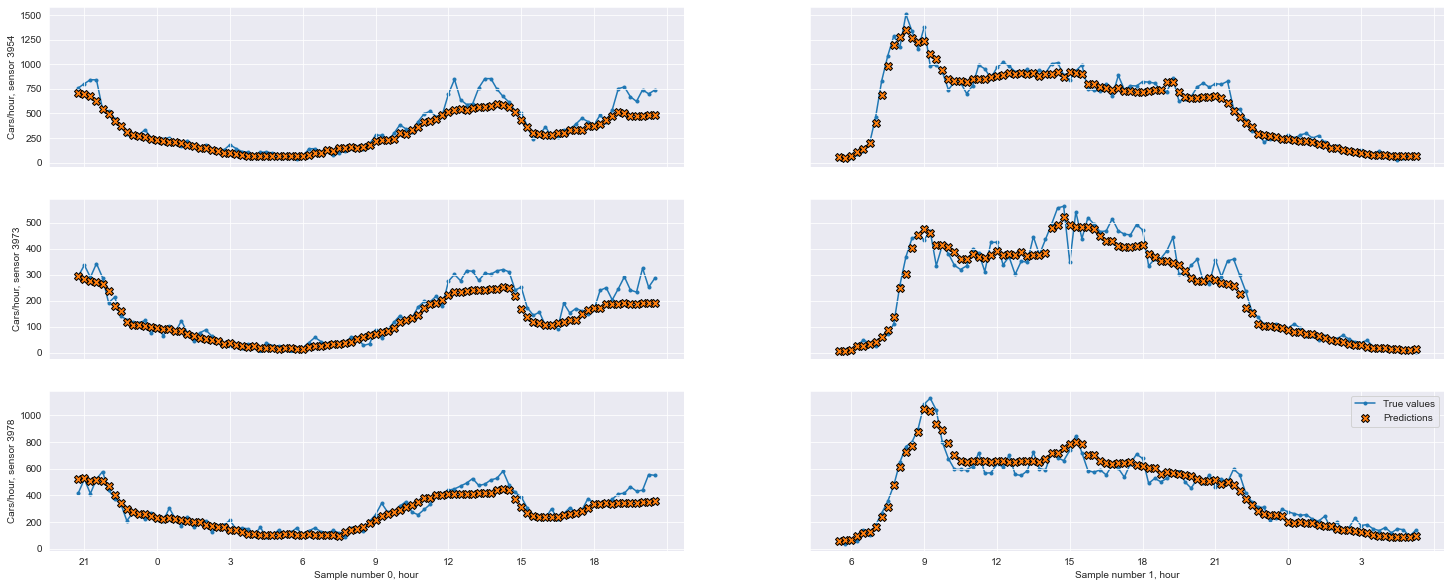

In [28]:
plot_predictions_from_features(estimators, test_x, test_y, random_samples, data_dict["ids_list"], data_dict["seq_len"])